In [22]:
import pandas as pd
import geopandas as gpd
from shapely import wkt, Polygon, distance, Point
from pyproj import Transformer

subset_keep = 0.8
cities = ["Aachen", "Dortmund", "Dresden", "Leipzig", "Mannheim", "Münster", "München", "Utrecht"]

cityhalls = pd.read_csv("../input/cityhalls.csv", index_col = 0)

city_dict = {}

for city in cities:
    city_data = pd.read_csv(f"../input/{city}/results.csv")
    city_data['geometry'] = city_data['geometry'].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(city_data, crs='epsg:25832')

    if city == "München":
        city_name_hall = "Muenchen"
    elif city == "Münster":
        city_name_hall = "Muenster"
    else:
        city_name_hall = city
    transformer = Transformer.from_crs("WGS84", "EPSG:25832")
    center = Point(transformer.transform(cityhalls.loc[city_name_hall].lat, cityhalls.loc[city_name_hall].lon))

    centroids = gdf.centroid
    point = centroids[0]
    distances = centroids.apply(distance, args = (center,))
    city_data.insert(6, "distance_to_middle", distances)

    number_keep = len(city_data) * subset_keep
    number_keep = round(number_keep)
    city_center = city_data.nsmallest(n = number_keep, columns = ["distance_to_middle"], keep = "all")
    city_keep80best90 = city_center.nlargest(round(0.9*len(city_center.index)), "score", keep = "all")

    city_center = gpd.GeoDataFrame(city_center, crs='epsg:25832')
    city_dict[city] = city_center

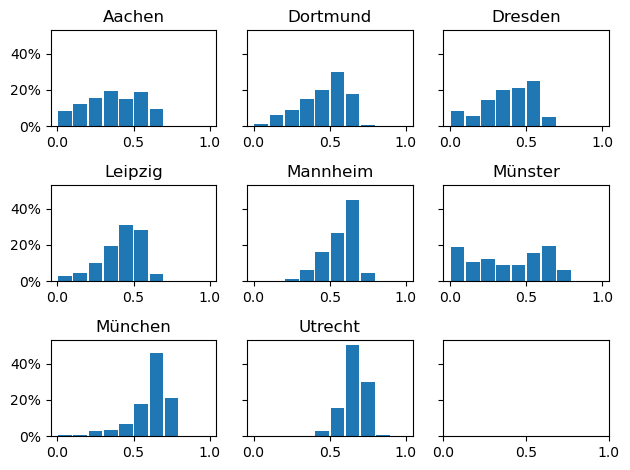

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

bins = 10
area = [0,1]

fig, axs = plt.subplots(3, 3, sharey=True, tight_layout=True)

for index in range(8):
    cityname = cities[index]
    citydata = city_dict[cityname]
    if index < 3:
        i = 0
        j = index
    elif index < 6:
        i = 1
        j = index -3
    else:
        i = 2
        j = index -6
    axs[i,j].hist(x = citydata.score, bins = bins, range = area, rwidth = 0.9, density = True)
    axs[i,j].yaxis.set_major_formatter(PercentFormatter(xmax=10))
    axs[i,j].set_title(cityname)

(array([1.1000e+01, 3.5000e+01, 1.6100e+02, 4.5900e+02, 1.3980e+03,
        2.9800e+03, 6.0340e+03, 9.7660e+03, 1.3587e+04, 1.5846e+04,
        1.5755e+04, 1.3566e+04, 9.6450e+03, 5.7620e+03, 2.9960e+03,
        1.3090e+03, 4.7100e+02, 1.5700e+02, 5.4000e+01, 8.0000e+00]),
 array([0.58818123, 1.02997676, 1.47177229, 1.91356782, 2.35536335,
        2.79715887, 3.2389544 , 3.68074993, 4.12254546, 4.56434099,
        5.00613652, 5.44793205, 5.88972757, 6.3315231 , 6.77331863,
        7.21511416, 7.65690969, 8.09870522, 8.54050075, 8.98229628,
        9.4240918 ]),
 <BarContainer object of 20 artists>)

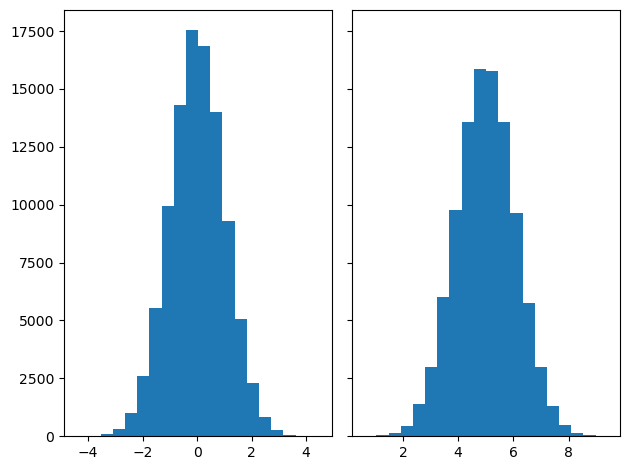

In [28]:
N_points = 100000
n_bins = 20

# Generate a normal distribution, center at x=0 and y=5
x = np.random.randn(N_points)
y = .4 * x + np.random.randn(100000) + 5

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x, bins=n_bins)
axs[1].hist(y, bins=n_bins)